In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import cosmology
from astropy.io import fits
from astropy import table
import SAGA

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [5]:
saga = SAGA.QuickStart(local_dir='../local_data/')
#'/path/to/saga/dropbox/folder', '/path/to/saga/local/folder')

SAGA `shared_dir` set to /Users/kadofong/work/surveys/saga/notebooks
SAGA `local_dir`  set to ../local_data/


In [6]:
saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"

In [7]:
saga.database["combined_base"].download(overwrite=False)

In [8]:
base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)

In [9]:
clean = base[(base['REMOVE']==0)&base['is_galaxy']].to_pandas ().set_index('OBJID')
clean = clean.loc[clean['ZQUALITY']>=3]
clean = clean.loc[clean['gr_err'] < 1.] # \\ have all colors measured 

# Found Yao's targeting code

In [252]:
from SAGA import targets

In [12]:
#out = targets.assign_targeting_score.assign_targeting_score_v3 ( base, ignore_specs=True)

In [13]:
# \\ only SAGA spec
telescopes = ['MMT','AAT']
lowz = clean.loc[np.in1d(clean['TELNAME'], telescopes)]

In [99]:
gama = fits.getdata('../../gama/local_data/StellarMassesLambdarv24.fits',1)
gama_phot = fits.getdata('../../gama/local_data/SersicCatSDSSv09.fits',1)

gama = table.Table(gama).to_pandas ()
gama = gama.set_index('CATAID')

gama_phot = table.Table(gama_phot).to_pandas ()
gama_phot = gama_phot.set_index('CATAID')

gama['GALSB_r'] = gama_phot['GALMAG_r'] + 2.5*np.log10(2.*np.pi*gama_phot['GALRE_r']**2)
gama['gminusr'] = gama_phot['GALMAG_g'] - gama_phot['GALMAG_r']
gama['GALMAG_r'] = gama_phot['GALMAG_r']
gama = gama.loc[(gama['gminusr']>-2)&(gama['gminusr']<3.)].copy()
gama = gama.query('Z<0.2')

In [100]:
g_matrix = [[0., 0., 0., 0.],
                [-0.900332, 3.97338, 0.774394, -1.09389],
                [3.65877, -8.04213, 11.0321, 0.781176],
                [-16.7457, -31.1241, -17.5553, 0],
                [87.3565, 71.5801, 0., 0.],
                [-123.671, 0, 0, 0]]
g_matrix = np.asarray(g_matrix)

r_matrix = [[0.,0.,0.,0.],
            [-1.61294, 3.81378, -3.56114, 2.47133],
            [9.13285, 9.85141, -5.1432, -7.02213],
            [-81.8341, -30.3631, 38.5052, 0.0],
            [250.732, -25.0159, 0.0, 0.0],
            [-215.377, 0.0, 0.0, 0.0]]
r_matrix = np.asarray(r_matrix)
            
kcorr_d = {'g':g_matrix,'r':r_matrix}
logml = lambda gr: 1.65*gr - 0.66

def kcorrect ( z, gr, bandpass ):
    if isinstance(z, float):
        kcorr_est = 0.
    else:
        kcorr_est = np.zeros(z.shape)
    for x_idx in range(5):
        for y_idx in range(4):
            coeff = kcorr_d[bandpass][x_idx, y_idx]
            term = coeff * z**x_idx * gr**y_idx
            kcorr_est += term
    return kcorr_est

def colormass_masses ( z, obsgr, Mr, zp_g = 5.11 ):
    kcorr_g = kcorrect ( z, obsgr, 'g' )
    kcorr_r = kcorrect ( z, obsgr, 'r' )
    gr_restframe = obsgr + kcorr_g - + kcorr_r
    M_g = Mr + gr_restframe
    
    loglum_g = (M_g-zp_g)/-2.5
    logsmass = logml(gr_restframe) + loglum_g    
    return logsmass

In [101]:
lowz['cm_mass'] = colormass_masses ( lowz['SPEC_Z'], lowz['gr'], lowz['Mr'] )
gama['Mr'] = gama['GALMAG_r'] - cosmo.distmod(gama['Z'].values).value 
gama['Mr'] -= kcorrect ( gama['Z'], gama['gminusr'], 'r')
gama['cm_mass'] = colormass_masses ( gama['Z'], gama['gminusr'], gama['Mr'] )

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/3600680718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowz['cm_mass'] = colormass_masses ( lowz['SPEC_Z'], lowz['gr'], lowz['Mr'] )


In [102]:
gama_rlim = 19.8
saga_rlim = 20.75
saga_grlim = lambda r: 0.9 - 0.06*(r-14.) # must be bluer than <
saga_sblim = lambda r: 18.5 + 0.7*(r-14.) # must be fainter than >

In [103]:
c_gama_sl = gama['gminusr'] <= saga_grlim(gama['GALMAG_r'])
c_gama_sl &= gama['GALSB_r'] >= saga_sblim(gama['GALMAG_r'])
#c_gama_sl &= gama['GALMAG_r'] <= gama_rlim # apply GAMA's own maglim
gama_sl = gama.loc[c_gama_sl].copy()

In [104]:
c_saga_gl = lowz['r_mag'] <= gama_rlim
c_saga_gl &= lowz['gr'] <= saga_grlim(lowz['r_mag']) # apply SAGA's own colorcut
c_saga_gl &= lowz['sb_r'] >= saga_sblim(lowz['r_mag']) # apply SAGA's own SB cut
saga_gl = lowz.loc[c_saga_gl].copy()

# Cut comparison

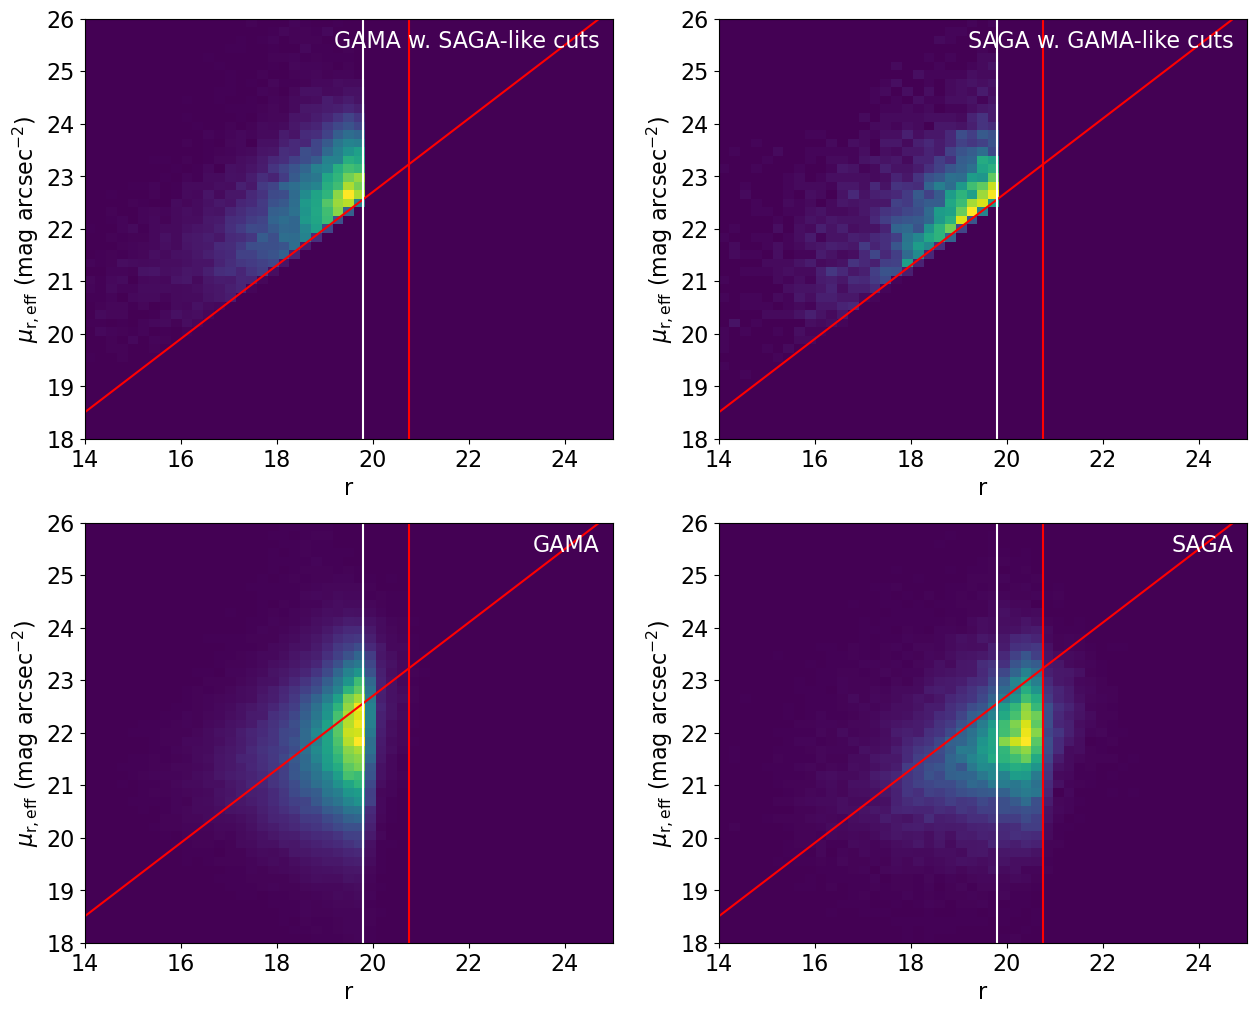

In [55]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(18.,26.,50)]
axarr[0,0].hist2d ( gama_sl['GALMAG_r'], gama_sl['GALSB_r'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['sb_r'], bins=bins_l)
axarr[1,0].hist2d ( gama['GALMAG_r'], gama['GALSB_r'], bins=bins_l)
axarr[1,1].hist2d ( lowz['r_mag'], lowz['sb_r'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_sblim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axvline(saga_rlim, color='r')
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\mu_{\rm r,eff}$ (mag arcsec$^{-2}$)')

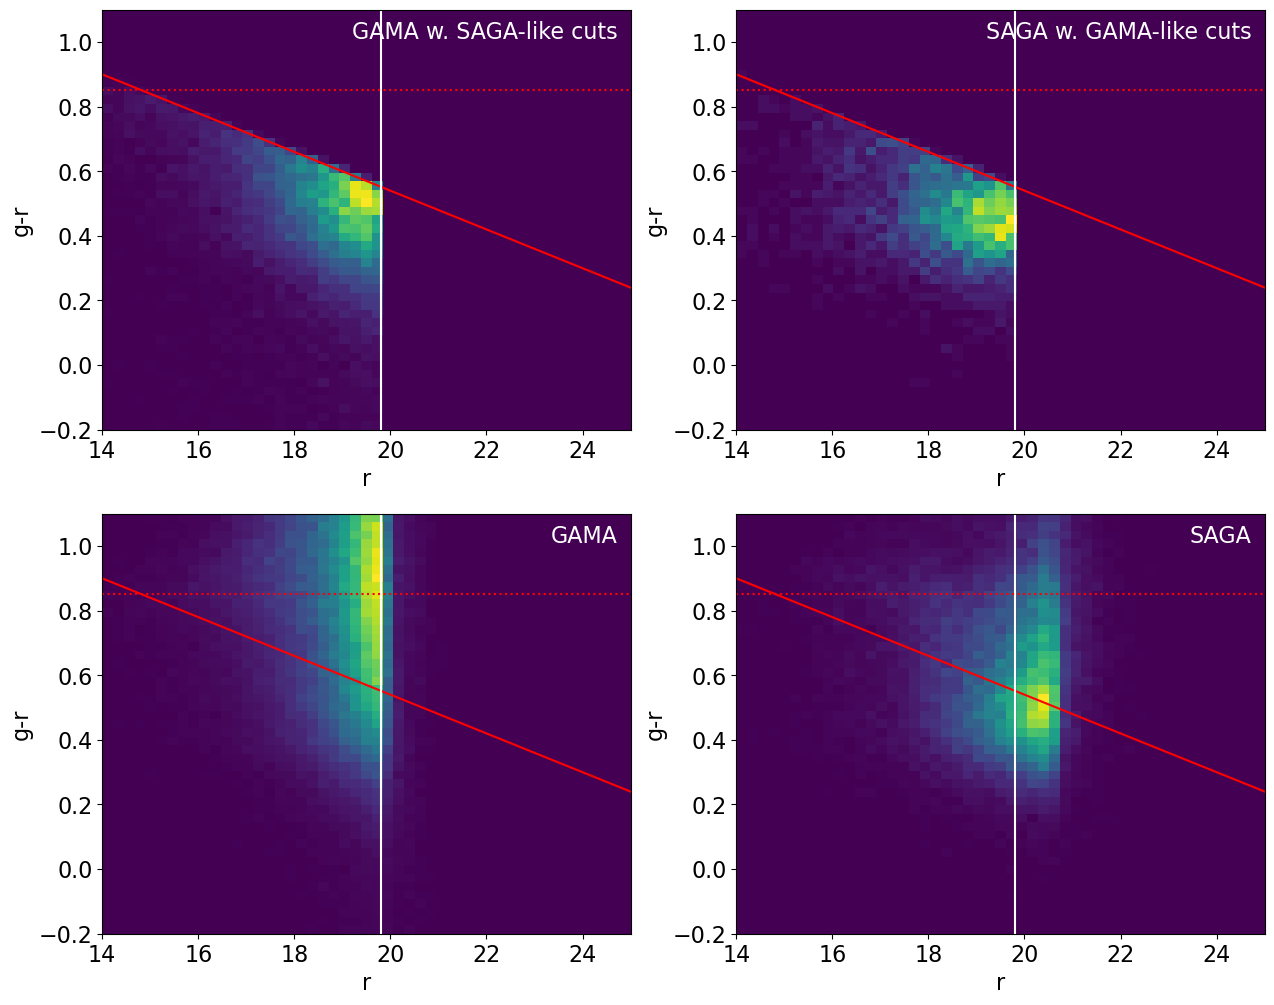

In [56]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(14.,25.,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['GALMAG_r'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['r_mag'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama['GALMAG_r'], gama['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( lowz['r_mag'], lowz['gr'], bins=bins_l)

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.axvline(gama_rlim, color='w')
    ax.axhline(0.85, color='r', ls=':')
    ax.set_xlabel('r')
    ax.set_ylabel('g-r')

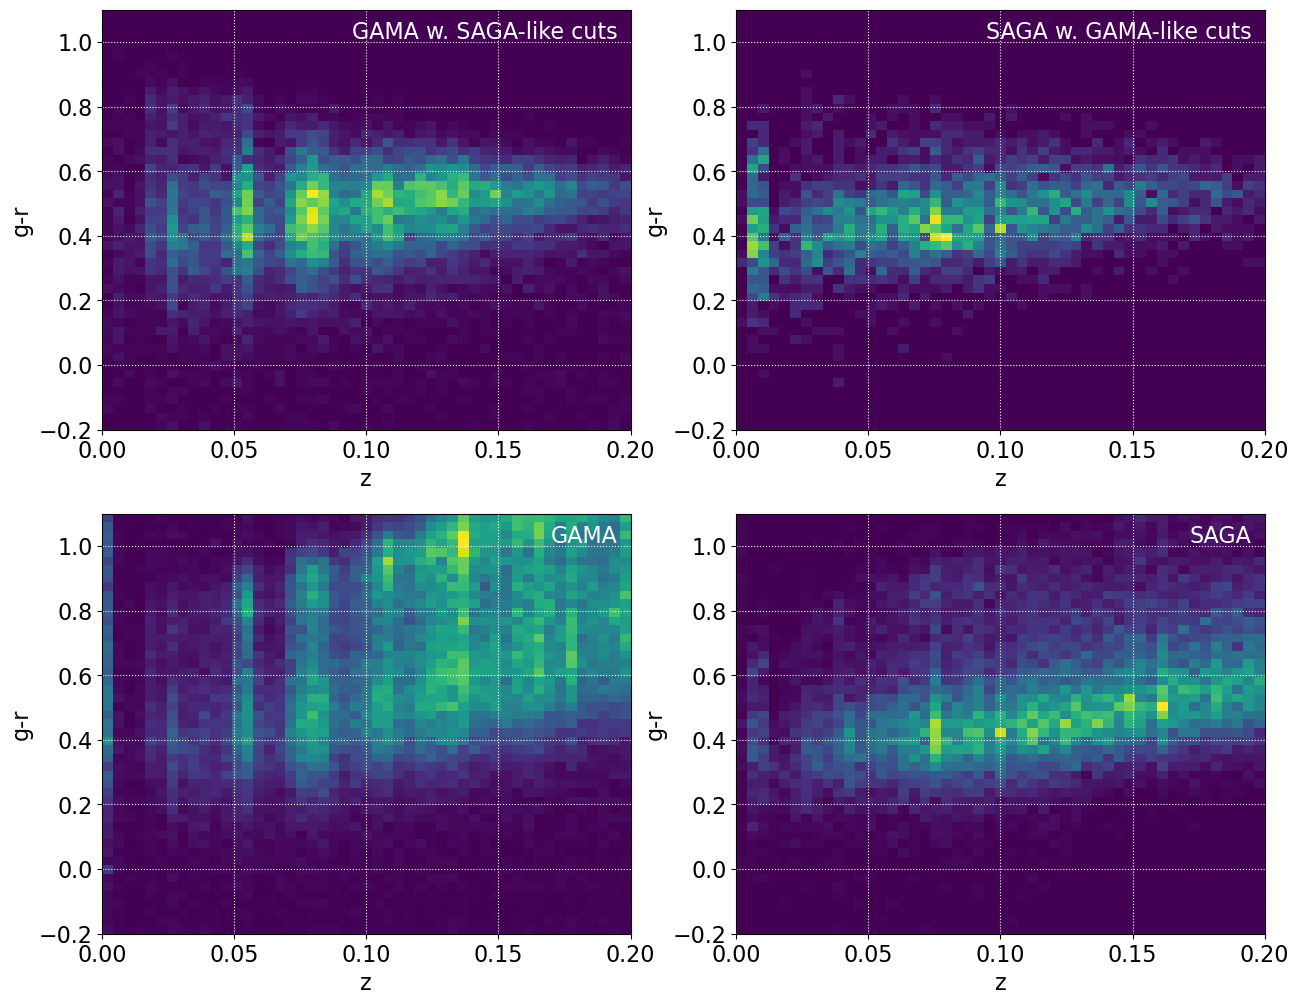

In [57]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-0.2,1.1,50)]
axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['gminusr'], bins=bins_l)
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['gr'], bins=bins_l)
axarr[1,0].hist2d ( gama['Z'], gama['gminusr'], bins=bins_l)
axarr[1,1].hist2d ( lowz['SPEC_Z'], lowz['gr'], bins=bins_l)



text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel('g-r')
    ax.grid(color='w',ls=':')

In [58]:
midpts = lambda x: 0.5*(x[1:]+x[:-1])

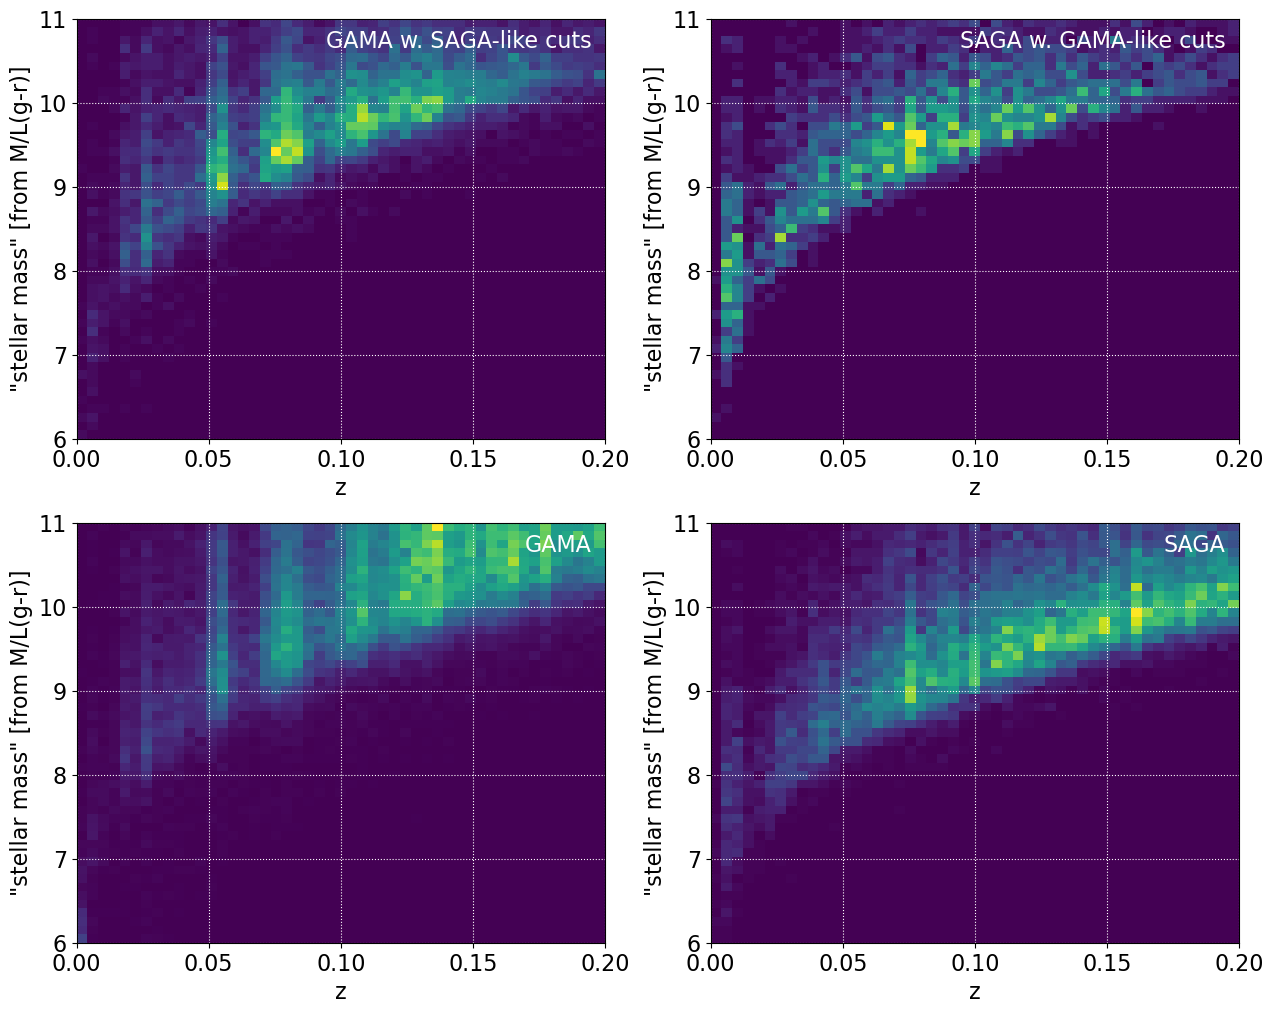

In [59]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(6.,11.,50)]
out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['cm_mass'], bins=bins_l)
axarr[1,0].hist2d( gama['Z'], gama['cm_mass'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['cm_mass'], bins=bins_l)
axarr[1,1].hist2d( lowz['SPEC_Z'], lowz['cm_mass'], bins=bins_l )
#axarr[1].contour (  midpts(out[1]), midpts(out[2]), out[0].T, colors='r')

text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )
    #ax.axvline(gama_rlim, color='w')
    ax.set_xlabel('z')
    ax.set_ylabel('"stellar mass" [from M/L(g-r)]')
    ax.grid(color='w',ls=':')

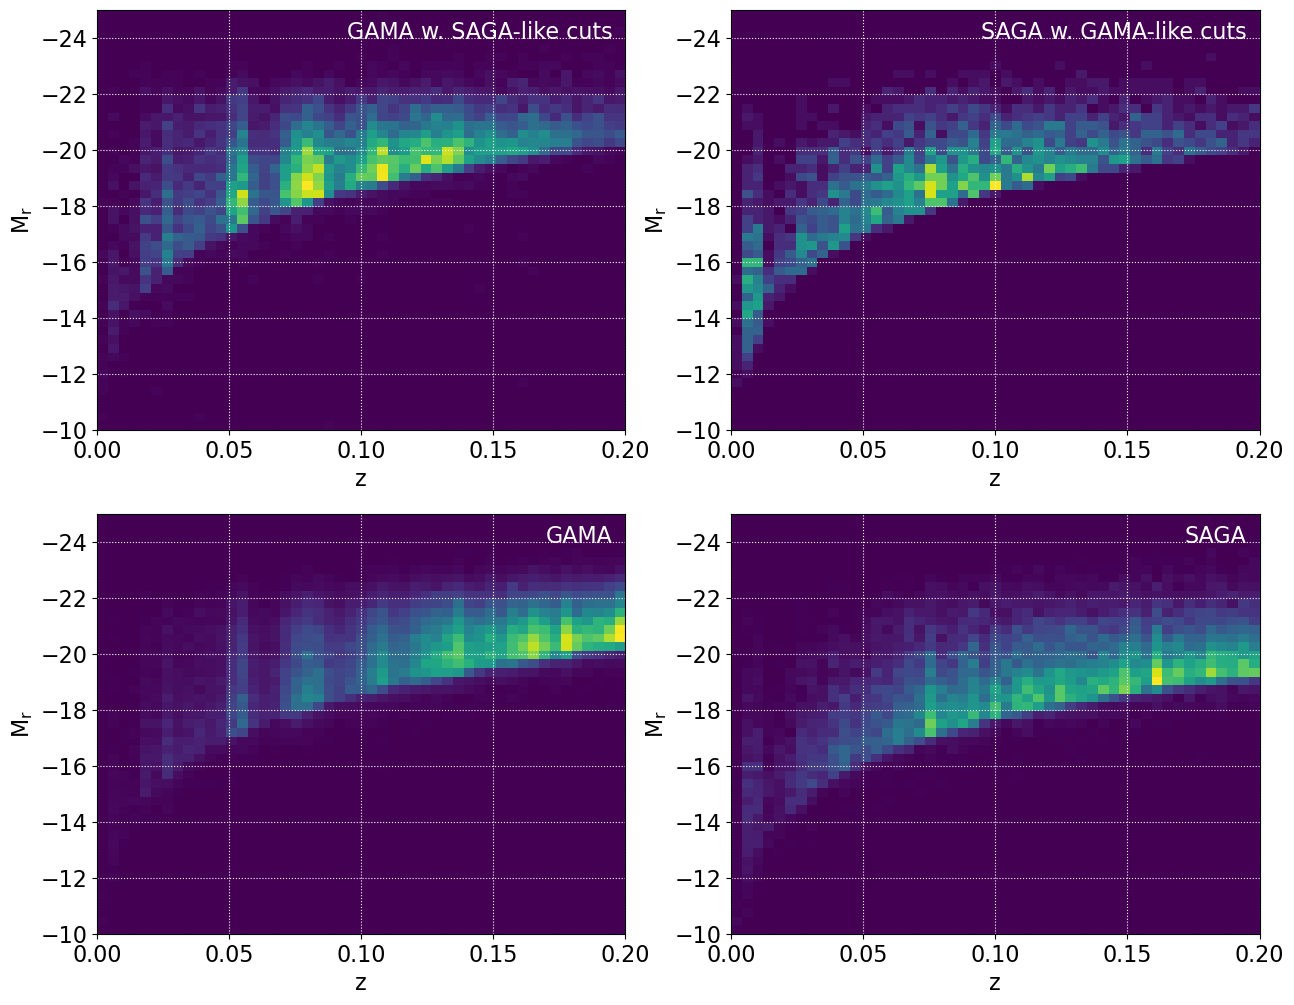

In [60]:
fig, axarr = plt.subplots(2,2,figsize=(15,6*2))
bins_l = [np.linspace(0., 0.2,50), np.linspace(-25,-10,50)]

out = axarr[0,0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
axarr[1,0].hist2d( gama['Z'], gama['absmag_r'], bins=bins_l )
axarr[0,1].hist2d ( saga_gl['SPEC_Z'], saga_gl['Mr'], bins=bins_l)
axarr[1,1].hist2d( lowz['SPEC_Z'], lowz['Mr'], bins=bins_l )


text = ['GAMA w. SAGA-like cuts', 'SAGA w. GAMA-like cuts', 'GAMA','SAGA']
for idx,ax in enumerate(axarr.flatten()):
    ax.plot ( bins_l[0], saga_grlim(bins_l[0]), color='r' )
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color='w', transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])

# Stats on SAGA primary targeting region

## Compare to full SAGA
TODO : what is the spectroscopic commitment of SAGA exploration mode? 50%?

In [27]:
c_saga_pt = lowz['gr'] <= saga_grlim(lowz['r_mag']) # apply SAGA's own colorcut
c_saga_pt &= lowz['sb_r'] >= saga_sblim(lowz['r_mag'])
saga_pt = lowz.loc[c_saga_pt].copy() # SAGA primary
saga_out = lowz.loc[~c_saga_pt].copy() # SAGA exploration
saga_out = saga_out.loc[saga_out['r_mag'] <= saga_rlim]

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/3721949583.py:11: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])


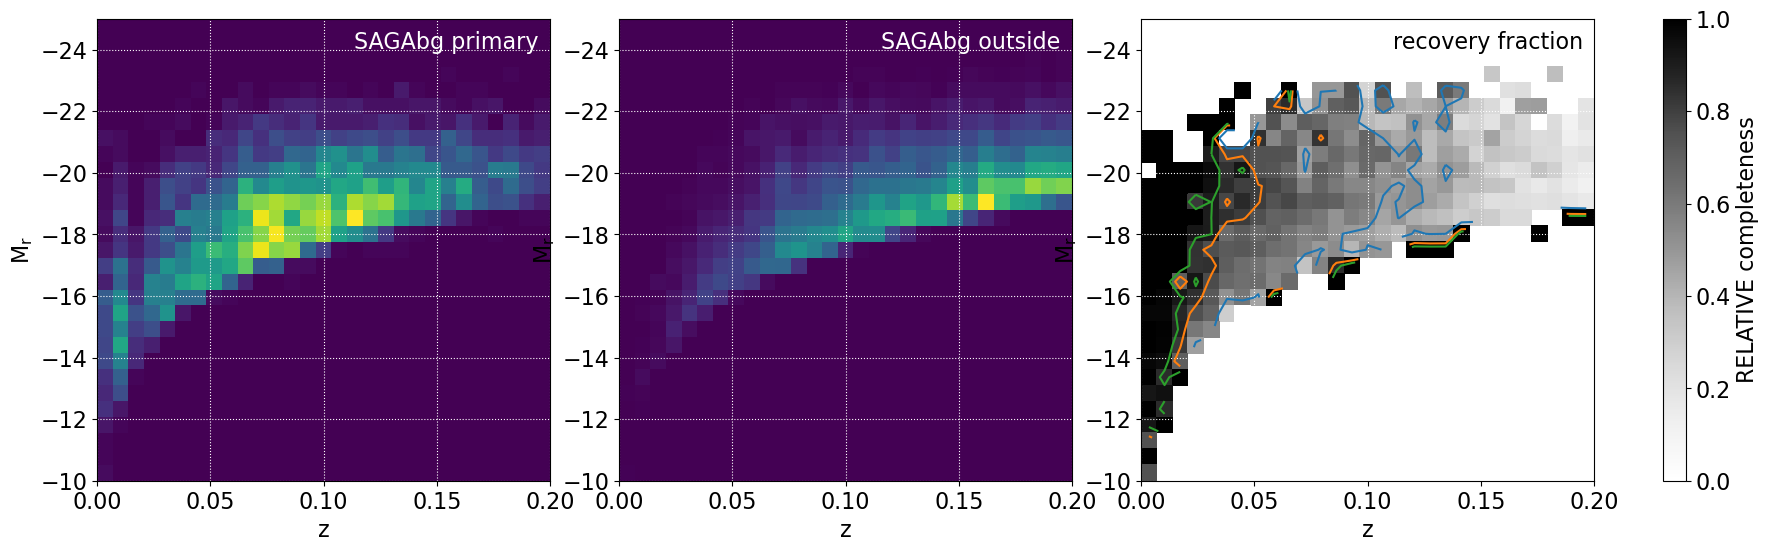

In [28]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( saga_pt['SPEC_Z'], saga_pt['Mr'], bins=bins_l)
outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['Mr'], bins=bins_l)

resource_factor = outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_pt.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg primary', 'SAGAbg outside', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/559856798.py:11: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])


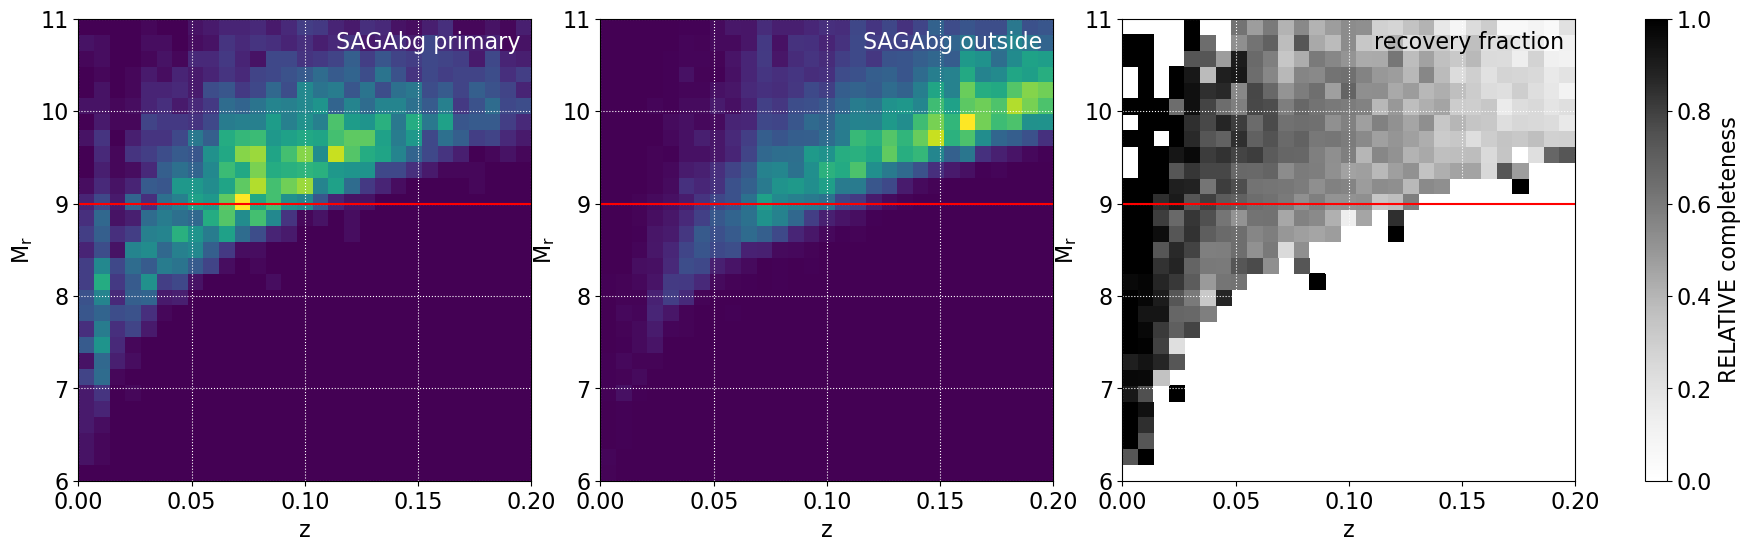

In [29]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 30
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( saga_pt['SPEC_Z'], saga_pt['cm_mass'], bins=bins_l)
outhist = axarr[1].hist2d ( saga_out['SPEC_Z'], saga_out['cm_mass'], bins=bins_l)

resource_factor = outhist[0].sum() / inhist[0].sum()
#saga_out.shape[0] / saga_pt.shape[0] # a very clumsy accounting for the
# fact that more spectra were taken in exploration mode
recfrac = inhist[0]*resource_factor/(inhist[0]*resource_factor+outhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
#axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='RELATIVE completeness')

text = ['SAGAbg primary', 'SAGAbg outside', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')

# Some stats noodling

In [91]:
# how probable is it to draw a negative number if 
# samples are unbalanced
Ux = np.random.uniform(0.,10.,100000)
ax = np.random.normal(5.,1.,1000)

In [116]:
pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
puniform = lambda x, xmin=0., xmax=10.: np.ones_like(x) / (xmax-xmin)

In [93]:
bins = np.arange(0.,10.,.25)

In [94]:
counts_ax = np.zeros_like(bins)
assns_ax, _counts_ax = np.unique(np.digitize(ax, bins), return_counts=True)
counts_ax[assns_ax] = _counts_ax
assns_ux, counts_ux = np.unique(np.digitize(Ux, bins), return_counts=True)

In [106]:
(Ux<5.).sum()

49787

In [109]:
.5*ax.size / (.5 * Ux.size) * Ux.size/ax.size

1.0

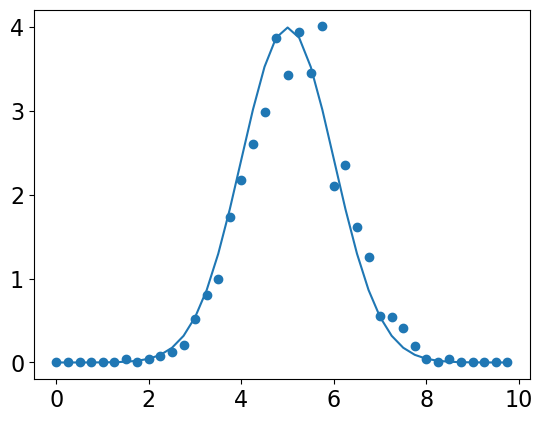

In [120]:
plt.plot(bins, pinside(bins)/puniform(bins))
#plt.plot(bins, puniform(bins))
plt.scatter(bins, counts_ax/counts_ux * Ux.size/ax.size)


In [144]:
#pinside = lambda x,m=5.,s=1.: (2.*np.pi*s**2)**(-0.5) * np.exp(-(x-m)**2/(2.*s**2))
p1 = lambda x: pinside(x, 5.,1.)
p2 = lambda x: pinside(x, 6.,2.)
s1 = np.random.normal(5.,1.,10000)
s2 = np.random.normal(6.,2.,12000)
bins = np.arange(0.,15.,.25)
counts_s1 = np.zeros_like(bins)
assns_s1, _counts_s1 = np.unique(np.digitize(s1, bins), return_counts=True)
counts_s1[assns_s1] = _counts_s1

counts_s2 = np.zeros_like(bins)
assns_s2, _counts_s2 = np.unique(np.digitize(s2, bins), return_counts=True)
counts_s2[assns_s2] = _counts_s2

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_2013/2390003158.py:2: RuntimeWarning: invalid value encountered in divide
  plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )


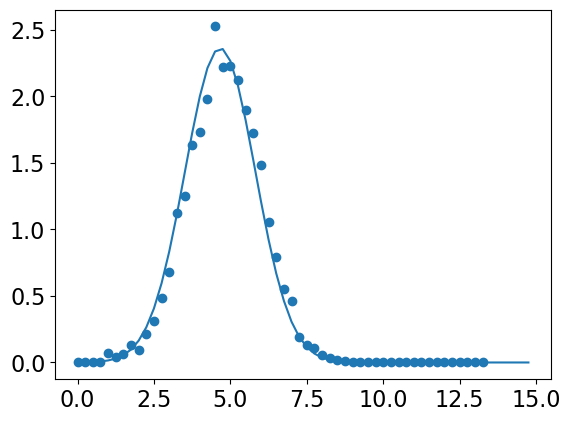

In [147]:
plt.plot(bins,p1(bins)/p2(bins))
plt.scatter(bins, counts_s1/counts_s2 * counts_s2.sum()/counts_s1.sum() )

# GAMA internal comparison

In [214]:
#c_gama_sl = gama['gminusr'] <= saga_grlim(gama['GALMAG_r'])
#c_gama_sl &= gama['GALSB_r'] >= saga_sblim(gama['GALMAG_r'])
#c_gama_sl &= gama['GALMAG_r'] <= gama_rlim # apply GAMA's own maglim
#gama_sl = gama.loc[c_gama_sl].copy() # GAMA, SAGA-like

In [105]:
#gama_out = gama.loc[gama['GALMAG_r']<=gama_rlim]
# lowz.loc[~c_saga_pt].copy()
gama_out = gama.loc[~c_gama_sl]
gama_out = gama_out.loc[gama_out['GALMAG_r']<=gama_rlim].copy()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/661152675.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


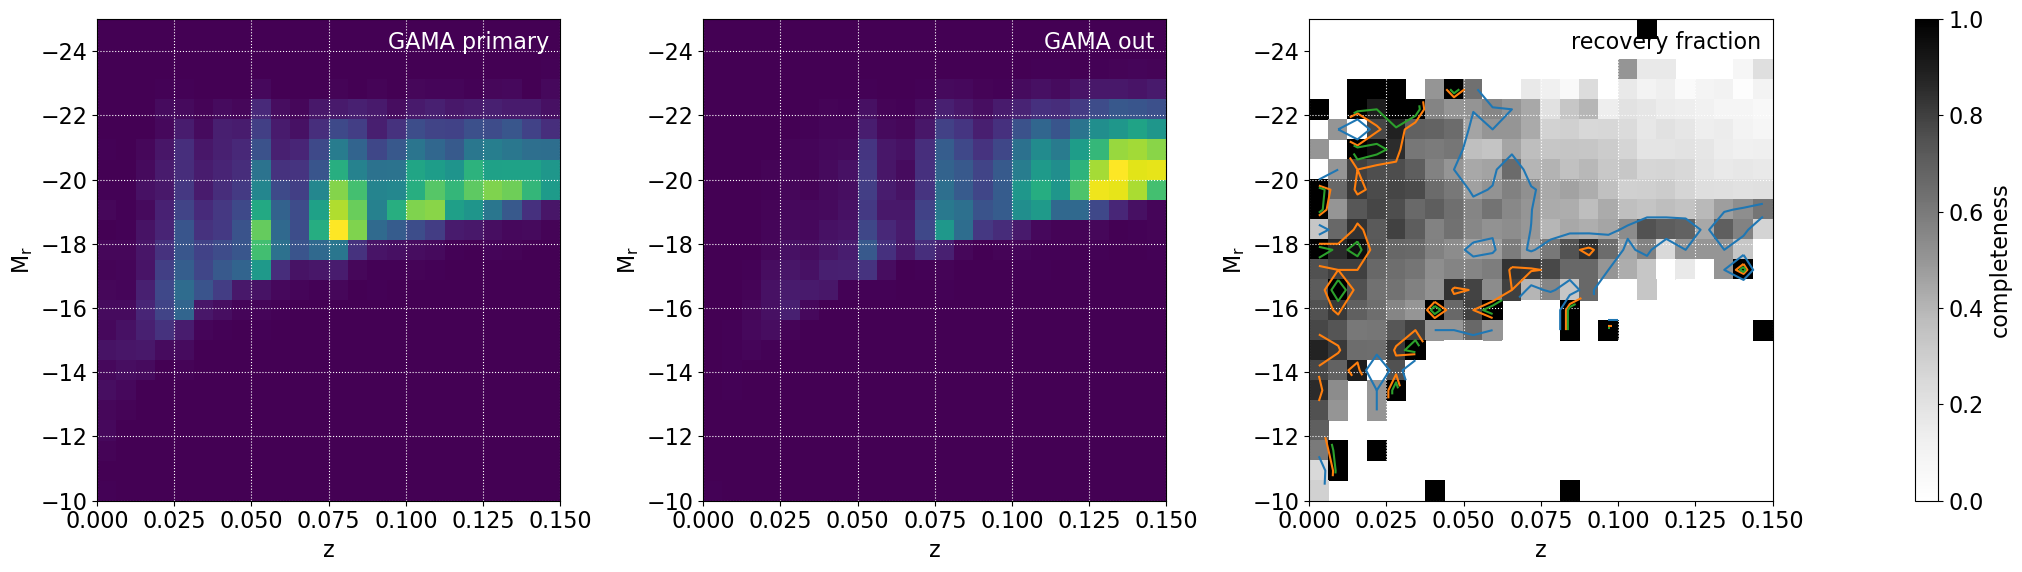

In [106]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.15,nbins), np.linspace(-25,-10,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['absmag_r'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['absmag_r'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='completeness')

text = ['GAMA primary', 'GAMA out', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )

    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout ()

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/3965764592.py:9: RuntimeWarning: invalid value encountered in divide
  recfrac = inhist[0]/(outhist[0]+inhist[0])


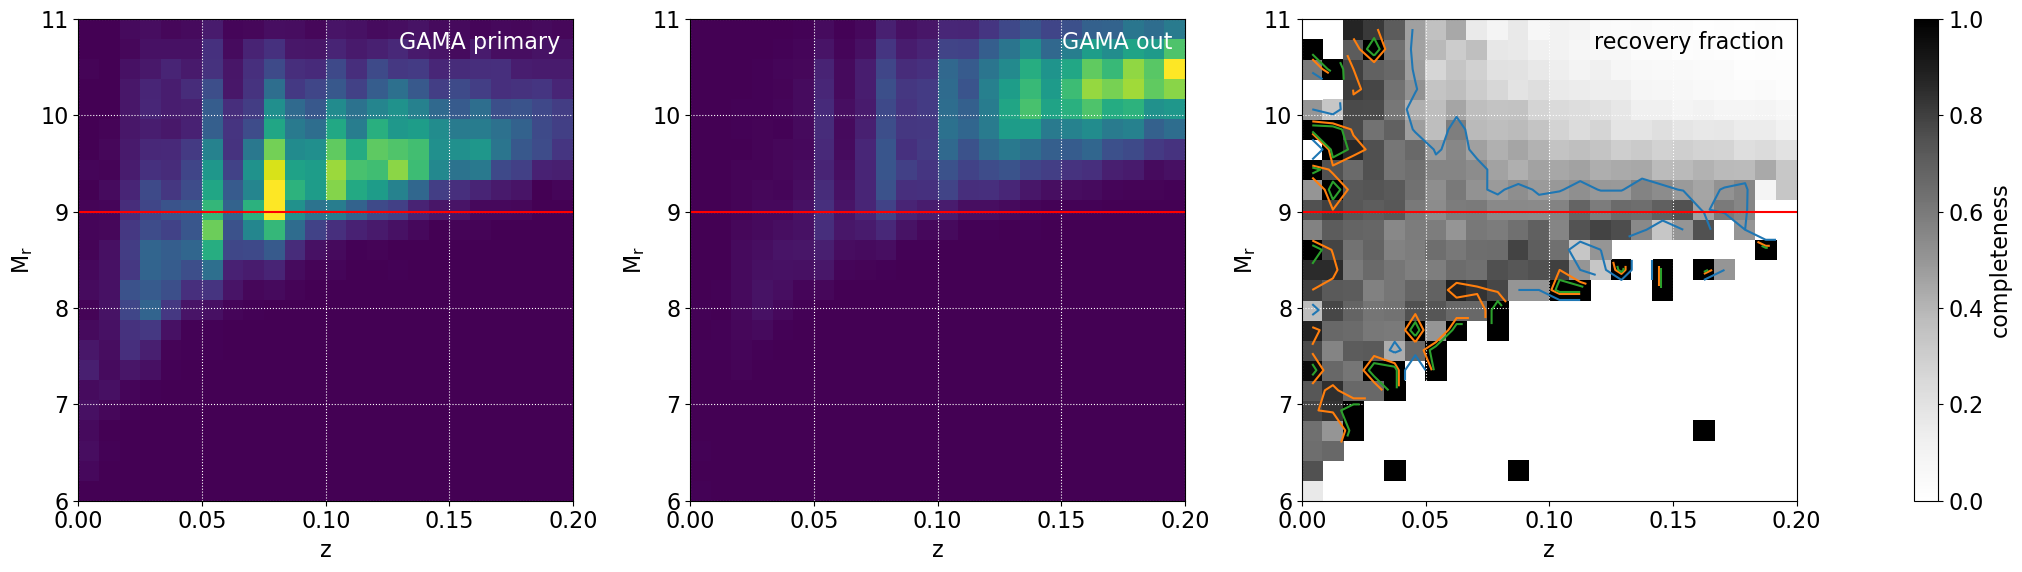

In [107]:
fig, axarr = plt.subplots(1,4,figsize=(5*4.1,6), gridspec_kw={'width_ratios':[1.,1.,1.,.05]})
nbins = 25
bins_l = [np.linspace(0., 0.2,nbins), np.linspace(6.,11.,nbins)]

inhist = axarr[0].hist2d ( gama_sl['Z'], gama_sl['logmstar'], bins=bins_l)
outhist = axarr[1].hist2d ( gama_out['Z'], gama_out['logmstar'], bins=bins_l)

# fact that more spectra were taken in exploration mode
recfrac = inhist[0]/(outhist[0]+inhist[0])
im = axarr[2].pcolor ( inhist[1], inhist[2], recfrac.T, cmap='Greys' )
axarr[2].contour ( midpts(inhist[1]), midpts(inhist[2]), recfrac.T, colors=['C0','C1','C2'], levels=[0.5,0.8,0.9])
plt.colorbar(im, cax=axarr[-1], label='completeness')

text = ['GAMA primary', 'GAMA out', 'recovery fraction']
cc_l = ['w','w','k']
for idx,ax in enumerate(axarr.flatten()[:-1]):
    ax.text ( 0.975, 0.975, text[idx], ha='right', va='top', color=cc_l[idx], transform=ax.transAxes )
    ax.set_xlabel('z')
    ax.set_ylabel(r'M$_{\rm r}$')
    ax.grid(color='w',ls=':')
    ax.axhline(9.,color='r')
    
plt.tight_layout ()

In [108]:
gama['in_saga'] = False
gama.loc[gama_sl.index,'in_saga']= True

In [111]:
import pandas as pd

In [112]:
zbins = np.linspace(0.,.2,20)
assns = np.digitize(gama['Z'], zbins)
completeness_df = pd.DataFrame()
completeness_df['zmed'] = np.NaN
completeness_df['grp'] = np.unique(assns)
for masslim in [9., 9.6]:
    ml = str(np.round(masslim,1))
    for name, grp in gama.groupby(assns):
        completeness_df.loc[name-1, 'zmed'] = zbins[name-1]
        is_dwarf = (grp['logmstar']<masslim)&(grp['logmstar']>6.)
        completeness_df.loc[name-1, f'dwarf_{ml}_completeness'] = grp.loc[is_dwarf, 'in_saga'].sum() / is_dwarf.sum()
        #completeness_df.loc[name-1, f'dwarf_{ml}_purity_gama'] = (grp.loc[grp.in_saga,'logmstar']<masslim).sum() / grp.in_saga.sum()


/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/1822831007.py:11: RuntimeWarning: invalid value encountered in long_scalars
  completeness_df.loc[name-1, f'dwarf_{ml}_completeness'] = grp.loc[is_dwarf, 'in_saga'].sum() / is_dwarf.sum()
/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_7283/1822831007.py:11: RuntimeWarning: invalid value encountered in long_scalars
  completeness_df.loc[name-1, f'dwarf_{ml}_completeness'] = grp.loc[is_dwarf, 'in_saga'].sum() / is_dwarf.sum()


In [113]:
completeness_df

,zmed,grp,dwarf_9.0_completeness,dwarf_9.6_completeness
0,0.000000,0.0,0.661905,0.665158
1,0.010526,1.0,0.637597,0.654424
2,0.021053,2.0,0.619919,0.642439
3,0.031579,3.0,0.561842,0.576340
4,0.042105,4.0,0.567816,0.571325
5,0.052632,5.0,0.537957,0.536920
6,0.063158,6.0,0.538324,0.540641
7,0.073684,7.0,0.523279,0.486097
8,0.084211,8.0,0.518717,0.470701
9,0.094737,9.0,0.495763,0.446979
